In [1]:
from os import getcwd, path, environ
import sys
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

BASE_PATH = getcwd()
sys.path.append(BASE_PATH)

environ['NUM_WORKERS'] = '0'
# environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [2]:
data = pd.read_csv('data/vn_sentiment/train.csv')

# replace new lines with space
data['comment'] = data['comment'].str.replace('\n', ' ')

data.head()

,id,comment,label
0,train_000000,Dung dc sp tot cam on shop Đóng gói sản phẩm ...,0
1,train_000001,Chất lượng sản phẩm tuyệt vời . Son mịn nhưng...,0
2,train_000002,Chất lượng sản phẩm tuyệt vời nhưng k có hộp ...,0
3,train_000003,:(( Mình hơi thất vọng 1 chút vì mình đã kỳ vọ...,1
4,train_000004,Lần trước mình mua áo gió màu hồng rất ok mà đ...,1


In [3]:
from sent_to_vec.masked_lm.bert_model import BertLMWrapper
from sent_to_vec.masked_lm.train import LanguageModelLearner
from sent_to_vec.masked_lm.vi_data import ViTextDataset

from common.modules import BertAdam
from common.callbacks import PrintLoggerCallback, EarlyStoppingCallback, ModelCheckpointCallback, TensorboardCallback, ReduceLROnPlateau

Default language for this instance: en


In [4]:
model = BertLMWrapper(from_fp='bert_vi_base.bin')
model.init_model()

dataset = ViTextDataset()
dataset.initialize(model, data_texts=list(data['comment']))

Featurizer previously fitted, continuing
Found 1321308 tokens
Top 5 words: <START>, <STOP>, <UNK>, <MASK>, ,


In [5]:
BATCH_SIZE = 16
n_epochs=10

learner = LanguageModelLearner(model,
    optimizer_fn=BertAdam,
    optimizer_kwargs={
        'lr': 1e-5,
        't_total': n_epochs * (len(dataset) // BATCH_SIZE),
        'warmup': 0.04
    })

Training in BERT mode


In [6]:
learner.fit(
    training_data=dataset,
    batch_size=BATCH_SIZE,
    epochs=n_epochs,
    callbacks=[
        PrintLoggerCallback(log_every=1, metrics=['loss']),
    ],
    gradient_accumulation_steps=10,
    clip_grad=1.0,
    fp16=True
)


Gradient accumulation is supported by this class
Number of tokens 30000
BertForMaskedLM(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30000, 512, padding_idx=0)
      (position_embeddings): Embedding(100, 512, padding_idx=0)
      (token_type_embeddings): Embedding(2, 512, padding_idx=0)
      (LayerNorm): FusedLayerNorm(torch.Size([512]), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=512, out_features=512, bias=True)
              (key): Linear(in_features=512, out_features=512, bias=True)
              (value): Linear(in_features=512, out_features=512, bias=True)
              (dropout): Dropout(p=0.1)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=512, out_features=512, 

3m 23s (- 3m 23s) (5 50%) - loss: 0.3461
4m 3s (- 2m 42s) (6 60%) - loss: 0.3361
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 262144.0
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 131072.0
4m 44s (- 2m 2s) (7 70%) - loss: 0.3354
5m 25s (- 1m 21s) (8 80%) - loss: 0.3305
6m 6s (- 0m 40s) (9 90%) - loss: 0.3295
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 131072.0
6m 46s (- 0m 0s) (10 100%) - loss: 0.3255


In [7]:
from text_classification.with_pretrained.model import LMClassifierWrapper
from text_classification.with_pretrained.train import LMClassifierLearner

In [8]:
classifier = LMClassifierWrapper({
    'encoder': model
})
classifier_learner = LMClassifierLearner(
    classifier,
    optimizer_fn='adam'
)

In [9]:
classifier_learner.fit(
    training_data=(data['comment'], data['label']), 
    batch_size=BATCH_SIZE,
    epochs=50, 
    callbacks=[PrintLoggerCallback(log_every=5)]
)

/media/luungoc2005/Data/Projects/botbot-nlp/common/wrappers.py:540: UserWarning: Error orcurred in multiprocessing.set_start_method
  warnings.warn('Error orcurred in multiprocessing.set_start_method')


1m 53s (- 16m 59s) (5 10%) - loss: 0.3927 - accuracy: 0.8597
3m 46s (- 15m 4s) (10 20%) - loss: 0.3798 - accuracy: 0.8715
5m 38s (- 13m 9s) (15 30%) - loss: 0.3644 - accuracy: 0.8759
7m 30s (- 11m 15s) (20 40%) - loss: 0.3556 - accuracy: 0.8785
9m 19s (- 9m 19s) (25 50%) - loss: 0.3551 - accuracy: 0.8784
11m 11s (- 7m 27s) (30 60%) - loss: 0.3464 - accuracy: 0.8843
13m 1s (- 5m 35s) (35 70%) - loss: 0.3455 - accuracy: 0.8837
14m 51s (- 3m 42s) (40 80%) - loss: 0.3363 - accuracy: 0.8874
16m 41s (- 1m 51s) (45 90%) - loss: 0.3362 - accuracy: 0.8877
18m 30s (- 0m 0s) (50 100%) - loss: 0.3327 - accuracy: 0.8910


In [10]:
test_data = pd.read_csv('data/vn_sentiment/test.csv')

# replace new lines with space
test_data['comment'] = test_data['comment'].str.replace('\n', ' ')

In [11]:
test_data.head()

,id,comment
0,test_000000,Chưa dùng thử nên chưa biết
1,test_000001,Không đáng tiềnVì ngay đợt sale nên mới mua n...
2,test_000002,Cám ơn shop. Đóng gói sản phẩm rất đẹp và chắc...
3,test_000003,Vải đẹp.phom oki luôn.quá ưng
4,test_000004,Chuẩn hàng đóng gói đẹp


In [12]:
import torch
test_item = [test_data['comment'][5]]
torch.softmax(classifier(test_item, return_logits=True)[0], dim=1)

tensor([[0.9162, 0.0402, 0.0437]], device='cuda:0')

In [13]:
classifier.save('bert_vi_sentiment.bin')

/media/luungoc2005/Data/Projects/botbot-nlp/common/wrappers.py:136: UserWarning: get_state_dict() is not implemented. Using default implementation
  warnings.warn('get_state_dict() is not implemented. Using default implementation')


In [14]:
raw_model = classifier.model

In [20]:
classifier.label_encoder.classes_.tolist().index(1)

1

tensor([[[ 0.0000e+00,  4.1127e-06,  4.8280e-06,  ...,  1.0000e+00,
          -7.6172e-01, -1.0000e+00],
         [-7.6172e-01,  0.0000e+00,  4.8280e-06,  ...,  9.9951e-01,
          -7.6172e-01, -1.0000e+00],
         [-9.6387e-01,  7.3730e-01,  2.5116e-02,  ...,  1.0000e+00,
          -7.6172e-01, -1.0000e+00],
         ...,
         [-1.0000e+00,  1.0000e+00,  1.0000e+00,  ...,  5.9605e-08,
          -7.6172e-01, -9.9512e-01],
         [-1.0000e+00,  1.0000e+00,  1.0000e+00,  ...,  0.0000e+00,
          -7.6172e-01, -9.6387e-01],
         [-1.0000e+00,  9.7949e-01,  1.0000e+00,  ...,  0.0000e+00,
          -7.6172e-01, -7.6172e-01]]], device='cuda:0', dtype=torch.float16,
       grad_fn=<CudnnRnnBackward>)
tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]], device='cuda:0')
[['<START>', '<UNK>', 'gói', 'sản', 'phẩm', 'r

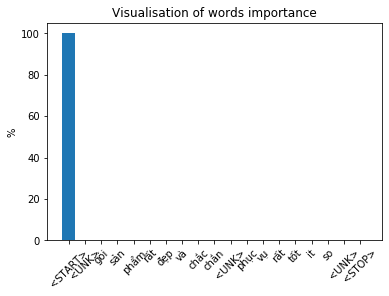

In [15]:
_, seq_tokens = raw_model.encoder(test_item)
sequence_output = raw_model.rnn(seq_tokens)[0]
print(sequence_output)

output, idxs = torch.max(sequence_output, 0)
print(idxs)
idxs = idxs.data.cpu().numpy()

sent = raw_model.encoder.featurizer.transform(test_item)
raw_sent = raw_model.encoder.featurizer.inverse_transform(sent)
print(raw_sent)

import matplotlib.pyplot as plt

argmaxs = [np.sum((idxs == k)) for k in range(len(sent[0]))]
# argmaxs[0] = 1e-8
print(argmaxs)
x = range(len(sent[0]))
y = [100.0 * n / np.sum(argmaxs) for n in argmaxs]
print(y)

plt.xticks(x, raw_sent[0], rotation=45)
plt.bar(x, y)
plt.ylabel('%')
plt.title('Visualisation of words importance')
plt.show()